In [1]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"nakulchamariya","key":"589927ae7c6e8d47e6ea59ec42178b84"}'}

In [2]:
!pip install kaggle

In [3]:
!rm -rf ~/.kaggle
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
# ! kaggle competitions download <name-of-competition>
!kaggle datasets download shwethlana/election-opinion-2019-and-2024sentiment-analysis

Dataset URL: https://www.kaggle.com/datasets/shwethlana/election-opinion-2019-and-2024sentiment-analysis
License(s): CC0-1.0
  0% 0.00/52.7k [00:00<?, ?B/s]
100% 52.7k/52.7k [00:00<00:00, 28.7MB/s]


In [5]:
!unzip /content/election-opinion-2019-and-2024sentiment-analysis.zip

Archive:  /content/election-opinion-2019-and-2024sentiment-analysis.zip
  inflating: lok_sabhaa.xlsx         
  inflating: predict lok sabha dataset.xlsx  


In [8]:
!rm -rf /content/sample_data /content/election-opinion-2019-and-2024sentiment-analysis.zip "/content/predict lok sabha dataset.xlsx"

In [ ]:
!pip install scikit-plot scipy==1.11.4

In [1]:
import os
os.kill(os.getpid(), 9)

TypeError: kill() takes exactly 2 arguments (1 given)

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
df = pd.read_excel('/content/lok_sabhaa.xlsx') # Read the dataset.
df.head(10)

,source,comments,sentiment
0,youtube,congress will always fail with pappu as their ...,positive
1,youtube,now india will move forward ...as one beacuse ...,positive
2,youtube,bjp up going to 2019 lock sabha,positive
3,youtube,"Only ABP does not have trust in Modi, everyon...",positive
4,youtube,congratulation ones agian in advance to my new...,positive
5,youtube,who will win ?,neutral
6,youtube,let them win first,negative
7,youtube,"The public of the country has been sold out, t...",negative
8,youtube,why did you vote for modi,negative
9,youtube,What did we get in UP? All we got is a fake go...,negative


In [4]:
df.shape

(997, 3)

In [5]:
df.columns

Index(['source', 'comments', 'sentiment'], dtype='object')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 997 entries, 0 to 996
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   source     997 non-null    object
 1   comments   996 non-null    object
 2   sentiment  995 non-null    object
dtypes: object(3)
memory usage: 23.5+ KB


In [7]:
df['source'].value_counts()

,count
source,
youtube,996
youtbe,1


In [8]:
df = df.drop(columns=['source'])
df.head()

,comments,sentiment
0,congress will always fail with pappu as their ...,positive
1,now india will move forward ...as one beacuse ...,positive
2,bjp up going to 2019 lock sabha,positive
3,"Only ABP does not have trust in Modi, everyon...",positive
4,congratulation ones agian in advance to my new...,positive


In [9]:
df['sentiment'].value_counts()

,count
sentiment,
positive,558
negative,428
neutral,8
ne,1


In [10]:
df = df[df['sentiment'].isin(['positive','negative'])]
df['sentiment'].value_counts()

,count
sentiment,
positive,558
negative,428


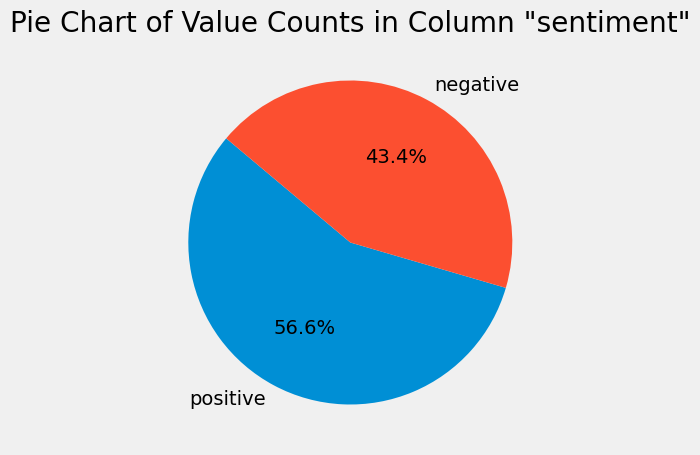

In [11]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

label_col_name = 'sentiment'
value_counts = df[label_col_name].value_counts()

plt.figure(figsize=(5, 5))
plt.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
plt.title(f'Pie Chart of Value Counts in Column \"{label_col_name}\"')
plt.grid()
plt.show()

In [12]:
df.head()

,comments,sentiment
0,congress will always fail with pappu as their ...,positive
1,now india will move forward ...as one beacuse ...,positive
2,bjp up going to 2019 lock sabha,positive
3,"Only ABP does not have trust in Modi, everyon...",positive
4,congratulation ones agian in advance to my new...,positive


In [13]:
X = df.drop(columns=['sentiment'])
y = df[['sentiment']]

In [14]:
X.head()

,comments
0,congress will always fail with pappu as their ...
1,now india will move forward ...as one beacuse ...
2,bjp up going to 2019 lock sabha
3,"Only ABP does not have trust in Modi, everyon..."
4,congratulation ones agian in advance to my new...


In [15]:
y.head()

,sentiment
0,positive
1,positive
2,positive
3,positive
4,positive


In [16]:
from sentence_transformers import SentenceTransformer

# 1. Load a pretrained Sentence Transformer model
emb_model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = emb_model.encode(sentences)
print(embeddings.shape)

(3, 384)


In [17]:
from tqdm.auto import tqdm
import numpy as np

X_emb = []
for idx, row in tqdm(X.iterrows(), total=X.shape[0]):
  embedding = emb_model.encode(row['comments'])
  X_emb.append(embedding)

X = np.array(X_emb)
X.shape

  0%|          | 0/986 [00:00<?, ?it/s]

(986, 384)

In [18]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [19]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((788, 384), (198, 384), (788, 1), (198, 1))

In [20]:
label = y_test['sentiment'].unique().tolist()
label

['negative', 'positive']

In [21]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, balanced_accuracy_score, log_loss, classification_report
import scikitplot as skplt

def evaluate_model(model, X_train, y_train, X_test, y_test, label, include_log_loss=True):
    print(f'Results for {model.__class__.__name__}:\n')

    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    print(f'Training time (sec) = {train_time}')

    y_pred_train = model.predict(X_train)

    start_time = time.time()
    y_pred_test = model.predict(X_test)
    test_time = time.time() - start_time
    print(f'Prediction time (sec) = {test_time}')

    y_pred_prob_train = model.predict_proba(X_train) if hasattr(model, 'predict_proba') else None
    y_pred_prob_test = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None

    confusion_mat = confusion_matrix(y_test, y_pred_test)
    misclassified = np.sum(y_pred_test != y_test.values.ravel())
    acc_train = balanced_accuracy_score(y_train, y_pred_train)
    acc_test = balanced_accuracy_score(y_test, y_pred_test)

    loss_train, loss_test = None, None
    if include_log_loss and y_pred_prob_test is not None:
        loss_train = log_loss(y_train, y_pred_prob_train)
        loss_test = log_loss(y_test, y_pred_prob_test)

    print(f'\nTraining score = {acc_train}')
    print(f'Testing score = {acc_test}\n')

    for i, class_label in enumerate(label):
        err = np.sum(confusion_mat[i]) - confusion_mat[i][i]
        print(f'No of misclassified for class {class_label} (test data) = {err}')

    print(f'Total no of misclassified points (test data) = {misclassified}')
    print(f'Total % of misclassified points (test data) = {misclassified / len(y_test)}\n')

    if loss_train is not None and loss_test is not None:
        print(f'Training log_loss = {loss_train}')
        print(f'Testing log_loss = {loss_test}\n')

    print('Confusion matrix:')
    skplt.metrics.plot_confusion_matrix(y_test, y_pred_test)
    plt.show()

    print('Classification report:\n')
    print(classification_report(y_test, y_pred_test))
    print('**************************************************************************')

    return [acc_train, acc_test, misclassified, misclassified / len(y_test), loss_train, loss_test, train_time, test_time]

Results for LogisticRegression:

Training time (sec) = 1.7385449409484863
Prediction time (sec) = 0.0010075569152832031

Training score = 0.7766829255500485
Testing score = 0.6961171096345515

No of misclassified for class negative (test data) = 30
No of misclassified for class positive (test data) = 29
Total no of misclassified points (test data) = 59
Total % of misclassified points (test data) = 0.29797979797979796

Training log_loss = 0.5240195337880489
Testing log_loss = 0.5910937047859784

Confusion matrix:


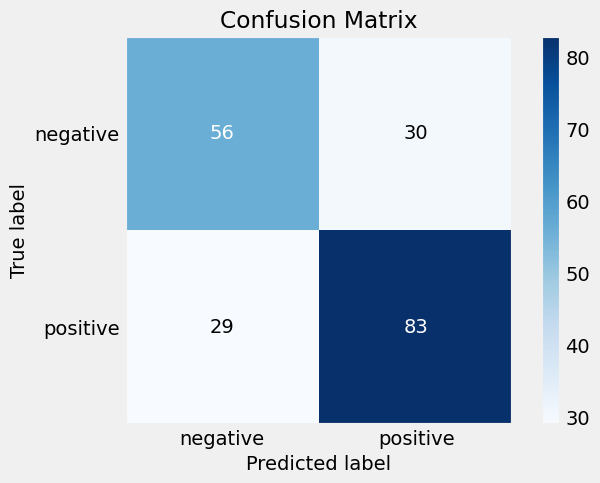

Classification report:

              precision    recall  f1-score   support

    negative       0.66      0.65      0.65        86
    positive       0.73      0.74      0.74       112

    accuracy                           0.70       198
   macro avg       0.70      0.70      0.70       198
weighted avg       0.70      0.70      0.70       198

**************************************************************************


In [22]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(class_weight='balanced', n_jobs=-1)
LR_results = evaluate_model(lr, X_train, y_train, X_test, y_test, label)

Results for LinearSVC:

Training time (sec) = 0.07101702690124512
Prediction time (sec) = 0.0007426738739013672

Training score = 0.8611438911179293
Testing score = 0.6992317275747508

No of misclassified for class negative (test data) = 31
No of misclassified for class positive (test data) = 27
Total no of misclassified points (test data) = 58
Total % of misclassified points (test data) = 0.29292929292929293

Confusion matrix:


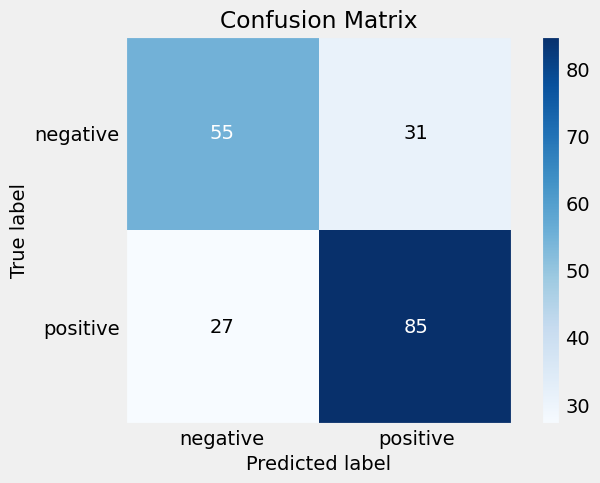

Classification report:

              precision    recall  f1-score   support

    negative       0.67      0.64      0.65        86
    positive       0.73      0.76      0.75       112

    accuracy                           0.71       198
   macro avg       0.70      0.70      0.70       198
weighted avg       0.71      0.71      0.71       198

**************************************************************************


In [23]:
from sklearn.svm import LinearSVC
lsvc = LinearSVC(class_weight='balanced')
LSVC_results = evaluate_model(lsvc, X_train, y_train, X_test, y_test, label)

Results for DecisionTreeClassifier:

Training time (sec) = 0.6171176433563232
Prediction time (sec) = 0.0008258819580078125

Training score = 1.0
Testing score = 0.5888704318936877

No of misclassified for class negative (test data) = 40
No of misclassified for class positive (test data) = 40
Total no of misclassified points (test data) = 80
Total % of misclassified points (test data) = 0.40404040404040403

Training log_loss = 2.2204460492503136e-16
Testing log_loss = 14.563092278431174

Confusion matrix:


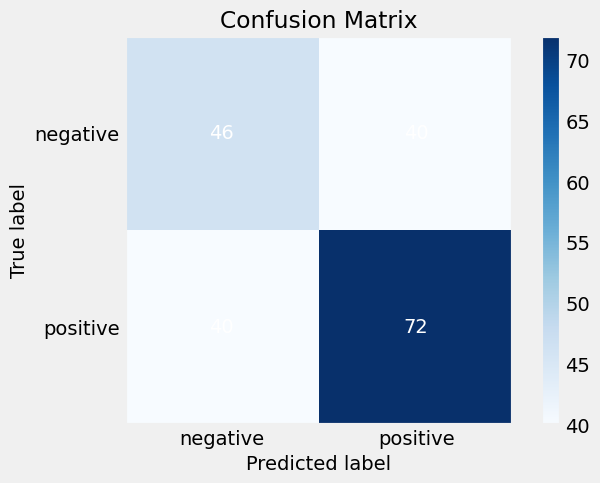

Classification report:

              precision    recall  f1-score   support

    negative       0.53      0.53      0.53        86
    positive       0.64      0.64      0.64       112

    accuracy                           0.60       198
   macro avg       0.59      0.59      0.59       198
weighted avg       0.60      0.60      0.60       198

**************************************************************************


In [24]:
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(class_weight='balanced')
DTC_results = evaluate_model(dtc, X_train, y_train, X_test, y_test, label)

Results for ExtraTreesClassifier:

Training time (sec) = 0.6179726123809814
Prediction time (sec) = 0.021433115005493164

Training score = 1.0
Testing score = 0.6628945182724253

No of misclassified for class negative (test data) = 48
No of misclassified for class positive (test data) = 13
Total no of misclassified points (test data) = 61
Total % of misclassified points (test data) = 0.30808080808080807

Training log_loss = 2.2204460492503136e-16
Testing log_loss = 0.5874401614684851

Confusion matrix:


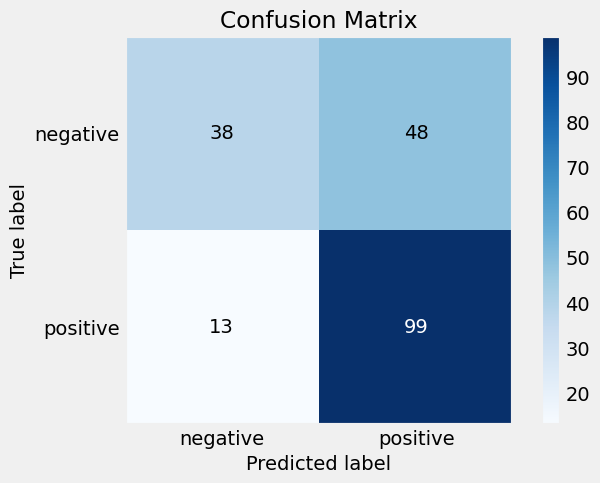

Classification report:

              precision    recall  f1-score   support

    negative       0.75      0.44      0.55        86
    positive       0.67      0.88      0.76       112

    accuracy                           0.69       198
   macro avg       0.71      0.66      0.66       198
weighted avg       0.70      0.69      0.67       198

**************************************************************************


In [25]:
from sklearn.ensemble import ExtraTreesClassifier
etc = ExtraTreesClassifier(class_weight='balanced')
ETC_results = evaluate_model(etc, X_train, y_train, X_test, y_test, label)

Results for RandomForestClassifier:

Training time (sec) = 1.963590383529663
Prediction time (sec) = 0.01655888557434082

Training score = 1.0
Testing score = 0.6634136212624585

No of misclassified for class negative (test data) = 41
No of misclassified for class positive (test data) = 22
Total no of misclassified points (test data) = 63
Total % of misclassified points (test data) = 0.3181818181818182

Training log_loss = 0.1679684404597236
Testing log_loss = 0.5863368057438142

Confusion matrix:


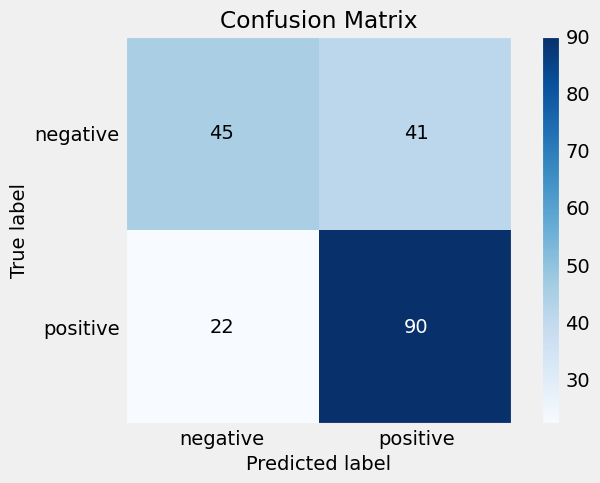

Classification report:

              precision    recall  f1-score   support

    negative       0.67      0.52      0.59        86
    positive       0.69      0.80      0.74       112

    accuracy                           0.68       198
   macro avg       0.68      0.66      0.66       198
weighted avg       0.68      0.68      0.67       198

**************************************************************************


In [26]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(class_weight='balanced')
RFC_results = evaluate_model(rfc, X_train, y_train, X_test, y_test, label)

In [27]:
s1=[LR_results,LSVC_results,DTC_results,ETC_results,RFC_results]
s2=['LR','LSVC','DTC','ETC','RFC']
col=['Train score','Test score','Missclassified-point','% missclasification','Train log-loss','Test log-loss','Training time','Prediction time']
result=dict.fromkeys(s2,None)

for i in range(len(s1)):
    result[s2[i]] = s1[i]

temp = pd.DataFrame.from_dict(result, orient='index',columns=col).reset_index()
result = temp.rename(columns={'index':'Classifiers'})
result

,Classifiers,Train score,Test score,Missclassified-point,% missclasification,Train log-loss,Test log-loss,Training time,Prediction time
0,LR,0.776683,0.696117,59,0.297980,5.240195e-01,0.591094,1.738545,0.001008
1,LSVC,0.861144,0.699232,58,0.292929,NaN,NaN,0.071017,0.000743
2,DTC,1.000000,0.588870,80,0.404040,2.220446e-16,14.563092,0.617118,0.000826
3,ETC,1.000000,0.662895,61,0.308081,2.220446e-16,0.587440,0.617973,0.021433
4,RFC,1.000000,0.663414,63,0.318182,1.679684e-01,0.586337,1.963590,0.016559


In [29]:
lr

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [30]:
import joblib
joblib.dump(lr, 'lr_model.joblib')

['lr_model.joblib']

#Prediction

In [31]:
df.columns

Index(['comments', 'sentiment'], dtype='object')

In [32]:
sample_data_point = df.sample(1)
sample_data_point.to_dict(orient='index')[sample_data_point.index[0]]

{'comments': 'i was against modi due to this corona pandemic but now when isee his work feel pround that he is building inida ',
 'sentiment': 'positive'}

In [35]:
import joblib
model_path = '/content/lr_model.joblib'
model_pipeline = joblib.load(sql_injection_model_path)

In [36]:
model_pipeline

LogisticRegression(class_weight='balanced', n_jobs=-1)

In [38]:
text = "i dont like this party. it will not win"
prediction = model_pipeline.predict([emb_model.encode(text)])[0]
prediction

'negative'